# **Importing Important Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

### If the GPU is available use it for the computation otherwise use the CPU.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_csv = pd.read_csv("/content/drive/MyDrive/karma/fashion_mnist/fashion-mnist_train.csv")
test_csv = pd.read_csv("/content/drive/MyDrive/karma/fashion_mnist/fashion-mnist_test.csv")

In [ ]:
print(train_csv.values.shape)
print(test_csv.values.shape)

(60000, 785)
(10000, 785)


In [ ]:
class FashionMnistDataset(Dataset):
    """ Class to load data. Here the input to the class is a pandas dataframe.
        This can be any serialized data collection. 
    """
    
    def __init__(self, data, transform = None):
        self.df_fashoin = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for sample in self.df_fashoin:
            label.append(sample[0])
            image.append(sample[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32') / 255.0

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionMnistDataset(train_csv, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))
test_set = FashionMnistDataset(test_csv, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [ ]:
## Checking
images, labels = iter(train_loader).next()
tmp_img = images[0]
# tmp_img

In [ ]:
def output_label(label):
  """
  """
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
images, labels = next(iter(train_loader))
images.size()

torch.Size([100, 1, 28, 28])

In [ ]:
len(train_set)

60000

2


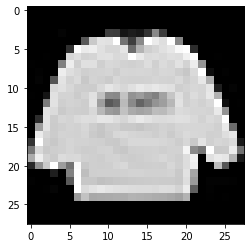

In [ ]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, T-shirt/Top, Bag, Ankle Boot, T-shirt/Top, Pullover, Pullover, Ankle Boot, Dress, Dress, Dress, Bag, Sneaker, Coat, Coat, T-shirt/Top, Coat, Coat, Bag, Sneaker, Trouser, Sandal, T-shirt/Top, Sandal, Dress, Pullover, Sneaker, Dress, Coat, Pullover, Trouser, Shirt, T-shirt/Top, Ankle Boot, Shirt, T-shirt/Top, Sandal, Shirt, Sneaker, Sneaker, Pullover, Sandal, Pullover, Pullover, Coat, Trouser, Coat, Ankle Boot, Bag, Dress, Coat, Sandal, Sandal, Shirt, Dress, Sandal, Bag, Sandal, Ankle Boot, Bag, Trouser, Pullover, Bag, Trouser, Dress, Shirt, Bag, Dress, Coat, Pullover, Sandal, T-shirt/Top, Pullover, Shirt, Bag, Trouser, Pullover, Sneaker, Shirt, Shirt, Coat, Shirt, Sandal, T-shirt/Top, Trouser, Sneaker, Dress, Sandal, Bag, Coat, Dress, 

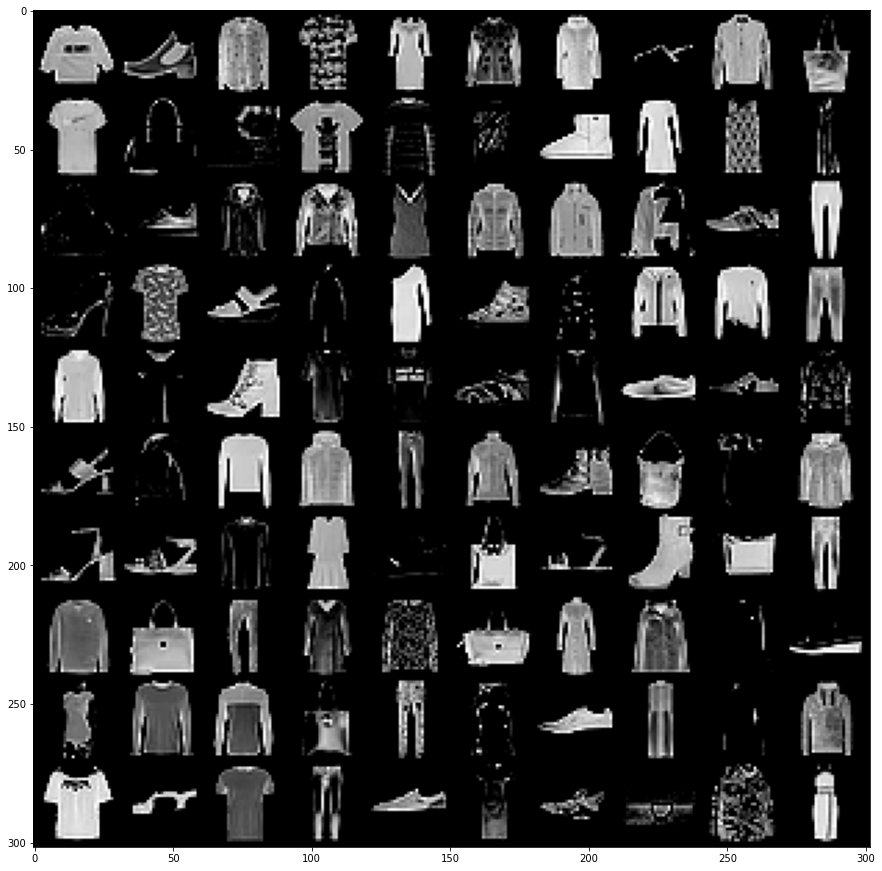

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")


In [ ]:
class VanillaCNN(nn.Module):
    
    def __init__(self):
        super(VanillaCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


### Making a model of our CNN class

*   Creating a object(model in the code)
*   Transfering it into GPU if available.
*  Defining a Loss function. we're using CrossEntropyLoss() here.
*  Using Adam algorithm for optimization purpose.



In [ ]:
model = VanillaCNN()
model.to(device)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

VanillaCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


## Training a network and Testing it on test dataset

In [ ]:
len(train_loader)

600

In [ ]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
train_losses, valid_losses = [], []
iteration_list = []
test_acc = []

# Lists for knowing classwise accuracy
predictions_list = []
val_acc_list = []

labels_list = []

min_valid_loss = np.inf

for epoch in range(num_epochs):
    running_loss = 0
    for images, labels in train_loader:
    
      # Transfering images and labels to GPU if available
      images, labels = images.to(device), labels.to(device)
  
      train = Variable(images.view(100, 1, 28, 28))
      labels = Variable(labels)
      
      # Forward pass 
      outputs = model(train)
      loss = loss_fn(outputs, labels)

      running_loss += loss.item()
      
      # Initializing a gradient as 0 so there is no mixing of gradient among the batches
      optimizer.zero_grad()
      
      #Propagating the error backward
      loss.backward()
      
      # Optimizing the parameters
      optimizer.step()

    
    # Testing the model
  
    total = 0
    correct = 0
    valid_loss = 0.0

    with torch.no_grad():
      model.eval()
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
    
        test = Variable(images.view(100, 1, 28, 28))
    
        outputs = model(test)
        loss = loss_fn(outputs, labels)
        valid_loss += loss.item()
    
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum() 
        total += len(labels)
        
    val_acc = correct * 100 / total

    epoch_training_loss = running_loss/len(train_loader)
    epoch_valid_loss = valid_loss/len(test_loader)

    train_losses.append(epoch_training_loss)
    valid_losses.append(epoch_valid_loss)
    iteration_list.append(epoch)
    val_acc_list.append(val_acc)

    if epoch_valid_loss < min_valid_loss:
      print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{epoch_valid_loss:.6f}) \t Saving The Model')
      min_valid_loss = epoch_valid_loss
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_valid_loss,
            }, f"/content/drive/MyDrive/karma/model_weights/saved_model_loss_{epoch_valid_loss:.2f}.pth")

      
    print(f"Epoch: {epoch}, Training Loss: {epoch_training_loss}, Testing Loss : {epoch_valid_loss} Test Accuracy: {val_acc}")

Validation Loss Decreased(inf--->0.398301) 	 Saving The Model
Epoch: 0, Training Loss: 0.4327846943835417, Testing Loss : 0.39830076639850936 Test Accuracy: 84.92333221435547
Validation Loss Decreased(0.398301--->0.232917) 	 Saving The Model
Epoch: 1, Training Loss: 0.2831412642573317, Testing Loss : 0.2329165468737483 Test Accuracy: 91.61833190917969
Validation Loss Decreased(0.232917--->0.196218) 	 Saving The Model
Epoch: 2, Training Loss: 0.24325629157324632, Testing Loss : 0.19621779138843218 Test Accuracy: 93.04166412353516
Validation Loss Decreased(0.196218--->0.186910) 	 Saving The Model
Epoch: 3, Training Loss: 0.22077497962862253, Testing Loss : 0.18690989499290783 Test Accuracy: 93.4000015258789
Validation Loss Decreased(0.186910--->0.178949) 	 Saving The Model
Epoch: 4, Training Loss: 0.20172447372227909, Testing Loss : 0.17894891884798805 Test Accuracy: 93.7683334350586


### Visualizing the Loss and Accuracy with Iterations


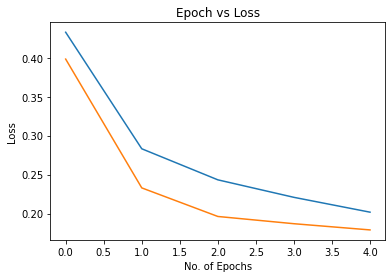

In [ ]:
plt.plot(iteration_list, train_losses)
plt.plot(iteration_list, valid_losses)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.show()

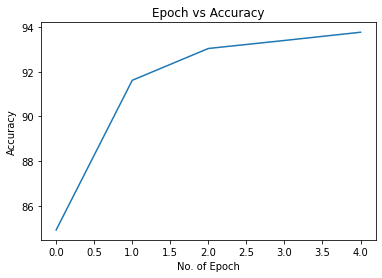

In [ ]:
plt.plot(iteration_list, val_acc_list)
plt.xlabel("No. of Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.show()

In [ ]:
# Define view_classify function
def view_classify(img, ps, version="Fashion"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().detach().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.cpu().resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [ ]:
def sing_image_inference(idx):
    sample = test_csv.iloc[idx]
    true_label = sample[0]
    image = sample[1:]
    image = np.asarray(image).reshape(28, 28, 1).astype('float32') / 255.0
    transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
    image = transformer(image).unsqueeze(0).to(device)
    probs = model(image).detach()
    m = nn.Softmax(dim=1)
    output_idx = int(torch.argmax(probs))
    view_classify(image,m(probs))

    print(f"True label: {output_label(true_label)}, Predicted label: {output_label(output_idx)}")  
   
    return  output_label(true_label), output_label(output_idx)

True label: Pullover, Predicted label: Pullover


('Pullover', 'Pullover')

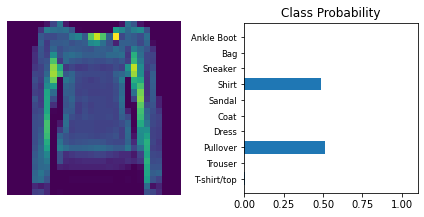

In [ ]:
sing_image_inference(2)

### Looking the Accuracy in each class of FashionMNIST dataset

In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 85.62%
Accuracy of Trouser: 99.13%
Accuracy of Pullover: 88.05%
Accuracy of Dress: 95.93%
Accuracy of Coat: 93.77%
Accuracy of Sandal: 96.83%
Accuracy of Shirt: 83.03%
Accuracy of Sneaker: 96.47%
Accuracy of Bag: 99.82%
Accuracy of Ankle Boot: 99.03%


### Per class performance statistics

In [ ]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [ ]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.92      0.78      0.85     30000
           1       0.99      0.98      0.99     30000
           2       0.92      0.81      0.86     30000
           3       0.91      0.94      0.93     30000
           4       0.87      0.87      0.87     30000
           5       0.99      0.98      0.98     30000
           6       0.68      0.84      0.75     30000
           7       0.98      0.95      0.96     30000
           8       0.98      0.99      0.99     30000
           9       0.95      0.99      0.97     30000

    accuracy                           0.91    300000
   macro avg       0.92      0.91      0.91    300000
weighted avg       0.92      0.91      0.91    300000


